In [45]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM # type: ignore
from tensorflow.keras.layers import Dense, Dropout # type: ignore

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error



%matplotlib inline

In [123]:

#bcm = pd.read_csv(r"C:\Users\Parsazh\Documents\GitHub\Machine-Learning\data\BCM_DATA.csv",index_col=[0],parse_dates=[0])
bcm_df_0 = pd.read_csv(r"..\data\BCM_DATA.csv")
bcm_df_0["ACC_MONTH"] = pd.to_datetime(bcm_df_0["ACC_MONTH"])
#bcm_df = bcm_df_0.loc[bcm_df_0['FISCAL_YEAR'] <= 2023]
bcm_df = bcm_df_0[[ "ACC_MONTH","TOT_PAID","NBR_MURDER","BUDGET_AMT"]] #,"FISCAL_YEAR", "ACCOUNTING_PERIOD","NBR_CASE","NBR_OTHER"

bcm_df_test = bcm_df_0.loc[bcm_df_0['FISCAL_YEAR'] > 2023].copy()
print(bcm_df.tail())



     ACC_MONTH    TOT_PAID  NBR_MURDER   BUDGET_AMT
162 2024-10-31  1708064.91          20  2656318.210
163 2024-11-30  1326014.32          14  3417666.784
164 2024-12-31  1659811.14          16  2071062.160
165 2025-01-31  2131294.37          19  3073348.775
166 2025-02-28  2398968.34          18  3173980.760


In [124]:

#Separate dates for future plotting
train_dates = pd.to_datetime(bcm_df['ACC_MONTH'])
#print(train_dates.tail(15)) #Check last few dates. 

#Variables for training
cols = list(bcm_df)[1:4]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['TOT_PAID', 'NBR_MURDER', 'BUDGET_AMT']


In [125]:
#New dataframe with only training data - 5 columns
df_for_training = bcm_df[cols].astype(float)
df_for_training.head()
#df_for_plot=df_for_training.tail(5000)
#df_for_plot.plot.line()

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
#print(df_for_training_scaled)

In [126]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 12  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
print(df_for_training.shape[1])
#exit()

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])


#print(trainX)    
#print(trainY)

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

3
trainX shape == (155, 12, 3).
trainY shape == (155, 1).


In [127]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


c:\GitHub\Machine-Learning\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 12, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

In [133]:
# fit the model
history = model.fit(trainX, trainY, epochs=8, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.0766 - val_loss: 0.7804
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7157 - val_loss: 0.8143
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7876 - val_loss: 0.8263
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8128 - val_loss: 0.7557
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7554 - val_loss: 0.8713
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8280 - val_loss: 0.8980
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7436 - val_loss: 0.7598
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6989 - val_loss: 0.7534


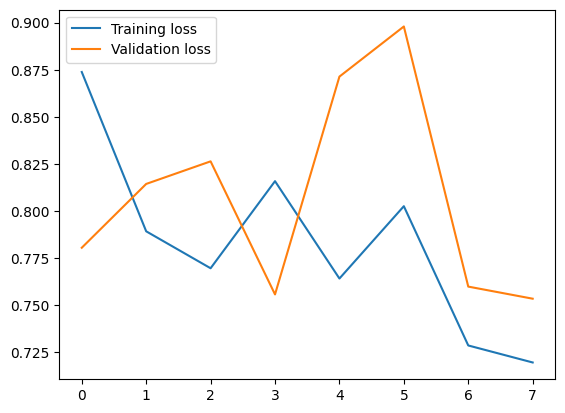

In [134]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [140]:
n_future = 18
forecast_period_date = pd.date_range(start='2025-03-31', periods=n_future,freq='ME').tolist() #list(train_dates)[-1]
#pd.date_range(start='2020-04-30',freq='ME', periods=12)
#print(train_dates)
print(len(forecast_period_date))
forecast = model.predict(trainX[-n_future:]) #forecast
print(forecast_period_date)
#print(forecast)

18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[Timestamp('2025-03-31 00:00:00'), Timestamp('2025-04-30 00:00:00'), Timestamp('2025-05-31 00:00:00'), Timestamp('2025-06-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-31 00:00:00'), Timestamp('2025-09-30 00:00:00'), Timestamp('2025-10-31 00:00:00'), Timestamp('2025-11-30 00:00:00'), Timestamp('2025-12-31 00:00:00'), Timestamp('2026-01-31 00:00:00'), Timestamp('2026-02-28 00:00:00'), Timestamp('2026-03-31 00:00:00'), Timestamp('2026-04-30 00:00:00'), Timestamp('2026-05-31 00:00:00'), Timestamp('2026-06-30 00:00:00'), Timestamp('2026-07-31 00:00:00'), Timestamp('2026-08-31 00:00:00')]


In [141]:
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]
print(y_pred_future)

[1940330.8 2029761.5 2135052.8 2094409.8 2146342.5 2276697.2 2243905.
 2132837.8 2140635.  1989290.1 1749536.9 1616654.1 1615292.5 1832930.
 1969153.2 2085114.4 2201278.2 2432332.8]


In [148]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_date:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'ACC_MONTH':np.array(forecast_dates), 'TOT_PAID':y_pred_future})
df_forecast['ACC_MONTH']=pd.to_datetime(df_forecast['ACC_MONTH'])
print(df_forecast)

    ACC_MONTH     TOT_PAID
0  2025-03-31  1940330.750
1  2025-04-30  2029761.500
2  2025-05-31  2135052.750
3  2025-06-30  2094409.750
4  2025-07-31  2146342.500
5  2025-08-31  2276697.250
6  2025-09-30  2243905.000
7  2025-10-31  2132837.750
8  2025-11-30  2140635.000
9  2025-12-31  1989290.125
10 2026-01-31  1749536.875
11 2026-02-28  1616654.125
12 2026-03-31  1615292.500
13 2026-04-30  1832930.000
14 2026-05-31  1969153.250
15 2026-06-30  2085114.375
16 2026-07-31  2201278.250
17 2026-08-31  2432332.750


<Axes: xlabel='ACC_MONTH', ylabel='TOT_PAID'>

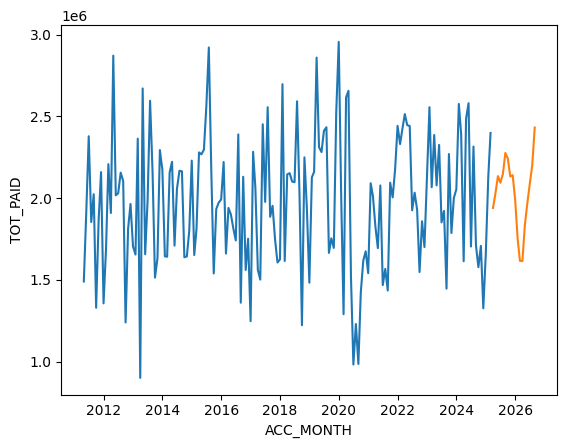

In [150]:

original = bcm_df_0[['ACC_MONTH', 'TOT_PAID']].copy()
original['ACC_MONTH']=pd.to_datetime(original['ACC_MONTH'])
#original = original.loc[original['ACC_MONTH'] >= '2024-04-30']
#df_forecast = df_forecast.loc[df_forecast["ACC_MONTH"] <'2025-04-30']
#print(original.head())
sns.lineplot(x= original['ACC_MONTH'], y= original['TOT_PAID'])
sns.lineplot(x=df_forecast['ACC_MONTH'], y=df_forecast['TOT_PAID'])

In [151]:
print(df_forecast)

    ACC_MONTH     TOT_PAID
0  2025-03-31  1940330.750
1  2025-04-30  2029761.500
2  2025-05-31  2135052.750
3  2025-06-30  2094409.750
4  2025-07-31  2146342.500
5  2025-08-31  2276697.250
6  2025-09-30  2243905.000
7  2025-10-31  2132837.750
8  2025-11-30  2140635.000
9  2025-12-31  1989290.125
10 2026-01-31  1749536.875
11 2026-02-28  1616654.125
12 2026-03-31  1615292.500
13 2026-04-30  1832930.000
14 2026-05-31  1969153.250
15 2026-06-30  2085114.375
16 2026-07-31  2201278.250
17 2026-08-31  2432332.750


In [ ]:
# df_merge = pd.merge(bcm_df_test[["ACC_MONTH","TOT_PAID"]],df_forecast[["ACC_MONTH","TOT_PAID"]],on='ACC_MONTH')

# mean_squared_error_LSTM = np.sqrt(mean_squared_error(y_true = df_merge['TOT_PAID_x'],y_pred=df_merge['TOT_PAID_y']))
# mean_absolute_error_LSTM=mean_absolute_error(y_true=df_merge['TOT_PAID_x'], y_pred=df_merge['TOT_PAID_y'])
# mean_absolute_percentage_error_LSTM=mean_absolute_percentage_error(y_true=df_merge['TOT_PAID_x'], y_pred=df_merge['TOT_PAID_y'])
# print(mean_squared_error_LSTM)
# print(mean_absolute_error_LSTM)
# print(mean_absolute_percentage_error_LSTM)

620499.1993534704
556516.4736363636
0.3079057490717191
